<div class = 'alert alert-info'> 
    <h1>Austin BCycle Station Analysis</h1>
    <p> Data is pulled from data.world in March 2020, and collected from weatherunderground and AustinBcycle in April-May 2016</p>
    <h2>Primary Goal</h2>
    <p>A cycle station can either be categorized as <b>active</b> or <b>inactive</b> depending on the number of bikes or docks available at a given time. When a station is considered INACTIVE, it is in one of two possible states:</p>
        <ol>
            <li>The station has no available bikes to check out (cannot start a ride).</li>
            <li>The station has no available docks to return a bike to (cannot end a ride)</li>
    </ol>
    <p>If neither of these conditions are true, the station is considered ACTIVE.
    </p>
    <p> In order to maximize customer satisfaction, inactive stations should be minimized as much as possible. In order to accomplish this goal, we need to identify stations which become inactive most frequently, and make suggestions to mitigate this effect.</p> 
    
<h2>Part 1 ‑ Data Cleaning & Exploratory data analysis</h2>

<h3>Objectives<br></h3>
<p>The Bcycle data was originally collected every 5 minutes from the Austin Bcycle website. I am going to aggregate these bike and dock counts based on daily and 1 hour time intervals, and then visualize and describe the resulting station activity. Next, I will report and illustrate important features of the activity, such as individual station variability and weather patterns. </p>
</div>

In [378]:
# package imports
import pandas as pd
import geopandas as gpd
import numpy as np 

# visualization imports 
import matplotlib.pyplot as plt
import seaborn as sns
import shapely.geometry as geo
%matplotlib inline

In [70]:
# import tables
bikes_raw = pd.read_csv('https://query.data.world/s/cxz3gqutkqnjvkdjnnjvlhouesfzw3', parse_dates=True)
stations_raw = pd.read_csv('https://query.data.world/s/yduqgj4j6ph5uicv2ukznkmy5rpey2')
weather_raw = pd.read_csv('https://query.data.world/s/7zgro4lpydwuiqikl5oigum4jrw6wi', parse_dates=True)

,Total,Percent
Events,29,47.540984
WindDirDegrees,0,0.000000
Max Sea Level PressureIn,0,0.000000
Max TemperatureF,0,0.000000
Mean TemperatureF,0,0.000000


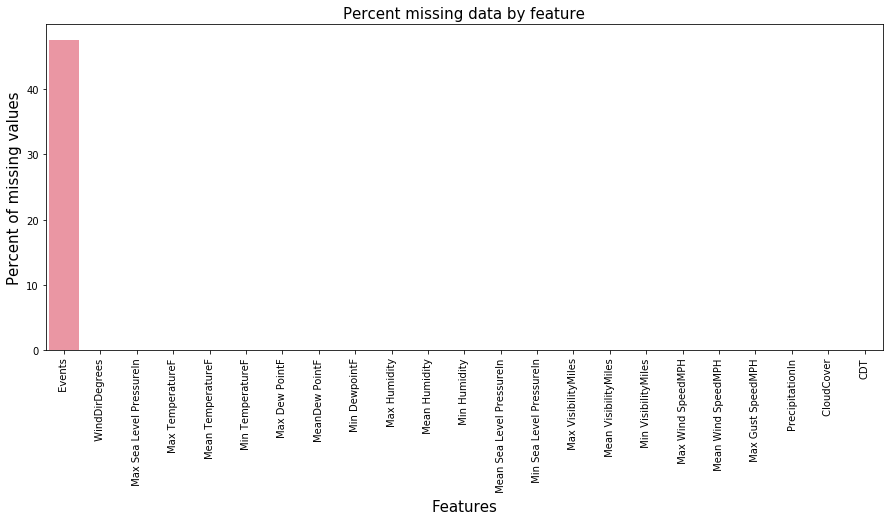

In [14]:
# before delving into statistics, check the null values 
total = weather_raw.isnull().sum().sort_values(ascending=False)
percent = (weather_raw.isnull().sum()/weather_raw.isnull().count() * 100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
missing_data.head()

<div class="alert alert-warning">
    Since the weather data was originally sampled from weather underground, I am able to fill the missing values with accurate event data from the given days.
</div>

In [71]:
# filled missing values by hand in excel... reupload cleaned version
weather_clean = pd.read_csv('weather.csv')

# convert cdt column to datetime objects and rename it 
weather_clean['CDT'] = pd.to_datetime(weather_clean['CDT'], infer_datetime_format=True)
weather_clean = weather_clean.rename(columns={"CDT":"date"})

In [72]:
# delete datetime column from stations
stations_clean = stations_raw.copy()
stations_clean.drop('datetime', axis=1, inplace=True)
#stations_clean.head()

In [73]:
# create a column to hold the location object
crs = {'init': 'EPSG:4326'}
location = [geo.Point(xy) for xy in zip(stations_clean["lat"], stations_clean['lon'])]
stations_geo = gpd.GeoDataFrame(stations_clean, crs = crs, geometry=location)
#stations_geo.head()

/Users/jillrosow/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [269]:
# convert date column to datetime 
bikes_clean = bikes_raw.copy()
bikes_clean['datetime'] = pd.to_datetime(bikes_clean['datetime'])

# add a column to to indicate station capacity
bikes_clean['station_capacity'] = [x + y for x,y in zip(bikes_clean.bikes, bikes_clean.docks)]

# add a columns to bikes to indicate if a station is full or empty; full=docks=0, empty=bikes=0
bikes_clean['empty'] = (bikes_clean.bikes == 0).astype('int64')
bikes_clean['full'] = (bikes_clean.docks == 0).astype('int64')

bikes_clean['temp'] = bikes_clean["empty"] + bikes_clean['full']

# add new column for active status
bikes_clean['active_status'] = [1 if x == 0 else 0 for x in bikes_clean['temp']]

# drop the temporary column 
bikes_clean.drop('temp', axis=1, inplace=True)

In [312]:
# merge stations and bikes 
bikes_stations = bikes_clean.merge(stations_geo, on='station_id')
bikes_stations.set_index(['station_id', 'name', 'datetime'], inplace=True)

In [363]:
# split the data into active and inactive stations 
active = bikes_stations[bikes_stations.active_status == 1]
inactive = bikes_stations[bikes_stations.active_status == 0]

In [313]:
# function for resampling
def resamp(df, freq):
    level_values = df.index.get_level_values
    return (df.groupby([level_values(i) for i in [0,1]] + 
                                             [pd.Grouper(freq=freq, level=-1)]).count())

In [371]:
# grab columns for graphing
station_inactivity = inactive.filter(['empty','full','active_status'], axis=1)
#station_activity = bikes_stations[['empty', 'full', 'active_status', 'name']]

daily_inactive = resamp(station_inactivity, 'D')
daily_inactive = daily_inactive.reset_index(level=[0, 1]) # undo multi index for ease
daily_inactive["day_of_week"] = daily_inactive.index.day_name()

daily_inactive_sums = pd.DataFrame(daily_inactive.groupby('day_of_week')['active_status'].count())
reorder_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_inactive_sums = daily_inactive_sums.reindex(reorder_list)

[Text(0.0, 0, 'Monday'),
 Text(0.2, 0, 'Tuesday'),
 Text(0.4, 0, 'Wednesday'),
 Text(0.6000000000000001, 0, 'Thursday'),
 Text(0.8, 0, 'Friday'),
 Text(1.0, 0, 'Saturday'),
 Text(0, 0, 'Sunday')]

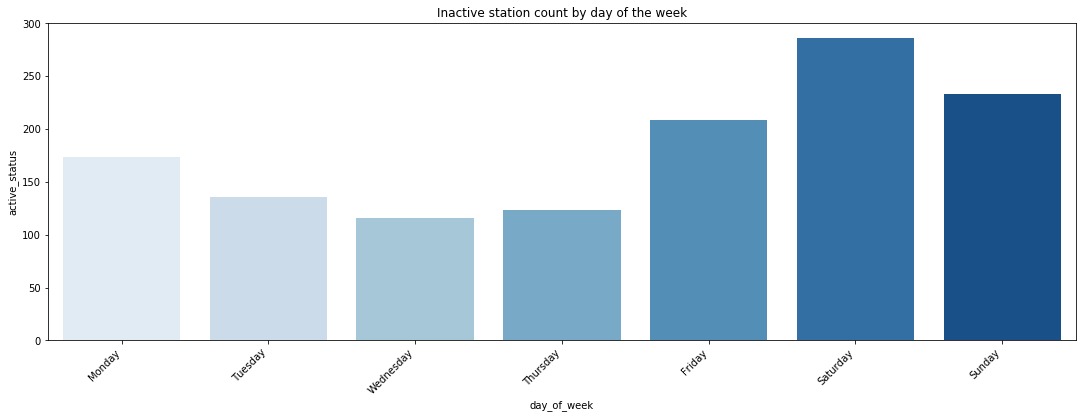

In [410]:
# visualize the entirety of the data 
fig, ax = plt.subplots(figsize=(15, 5))
plt.tight_layout()
chart = plt.xlabel("Day of the week")
chart = plt.ylabel("Number of inactive stations")
chart = plt.title("Inactive station count by day of the week")
chart = sns.barplot(daily_inactive_sums.index, daily_inactive_sums.active_status, palette="Blues")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

<div class="alert alert-success">
    This graph shows that stations are inactive most often on weekends, especially Saturdays. 

</div>

In [407]:
# do a line graph with hue = week day and x axis = hour 
hourly_inactive = resamp(station_inactivity, 'H')
hourly_inactive = hourly_inactive.reset_index(level=[0, 1]) # undo multi index for ease
hourly_inactive["day_of_week"] = hourly_inactive.index.day_name()
hourly_inactive['hour'] = [time.hour + 1 for time in hourly_inactive.index]

# reorder by day of week 
hourly_inactive = pd.pivot_table(hourly_inactive, values = 'active_status', index = 'day_of_week', columns='hour', aggfunc='count')
hourly_inactive = hourly_inactive.reindex(reorder_list)

# stack
avg_hourly_inactive = hourly_inactive.stack(level=['hour'])
# name the stack
avg_hourly_inactive.name = 'avg_num_inactives'
avg_hourly_inactive_df = avg_hourly_inactive.reset_index()
#hourly_inactive_sums = pd.DataFrame(hourly_inactive.groupby(hourly_inactive.index)['active_status'].count())
#hourly_inactive_sums = hourly_inactive_sums.reindex(reorder_list)

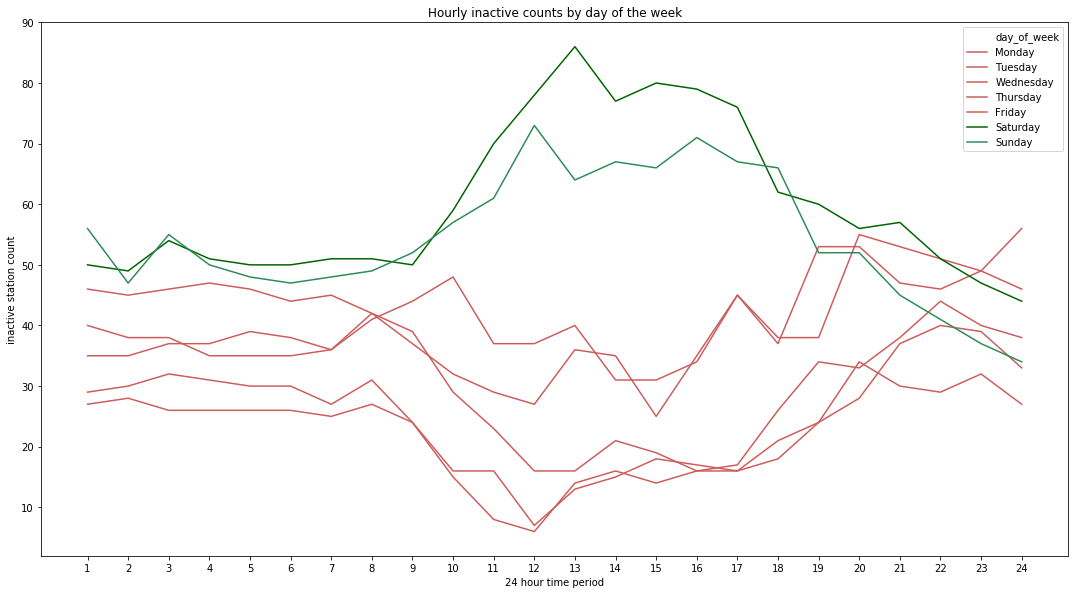

In [458]:
# graph set up
fig, ax = plt.subplots(figsize = (15,8))
plt.tight_layout()
_ = plt.xticks([x for x in range(1, 25)])
_ = sns.lineplot(x="hour", y="avg_num_inactives", data=avg_hourly_inactive_df, hue="day_of_week", palette=['indianred', 'indianred', 'indianred', 'indianred', 'indianred', 'darkgreen', 'seagreen'])
_ = plt.title("Hourly inactive counts by day of the week")
_ = plt.xlabel("24 hour time period")
_ = plt.ylabel('inactive station count')

<div class="alert alert-success">
  <p>  After separating by hour, we can see that during weekends (highligted in green), stations are most likely to be inactive from around 9am to 7pm. This is likely attributable to bikers taking leisure rides during the daytime on weekends, which is common around Town Lake in Austin. </p>
   <p>Weekdays (highlighted in red), show an opposite pattern: station inactivity levels are higher in the morning and evening than during the daytime. This is probably due to users taking trips to commute to work.</p>
</div>

In [444]:
#station_activity = bikes_stations.filter(['empty','full','active_status'], axis=1)
inactive_counts = station_inactivity.groupby('name')['active_status', 'empty', 'full'].count()
inactive_counts.sort_values(by=['active_status'], ascending=False, inplace=True)

In [445]:
# want to look at the percentage of time each station is inactive
# add a column for percent of time that the station is inactive 
all_counts = station_activity.groupby('name')['active_status', 'empty', 'full'].count()
all_counts.sort_values(by=['active_status'], ascending=False, inplace=True)

In [454]:
percent_inactive = pd.DataFrame(inactive_counts.active_status / all_counts.active_status * 100)
percent_inactive.sort_values(by=['active_status'], ascending=False, inplace=True)

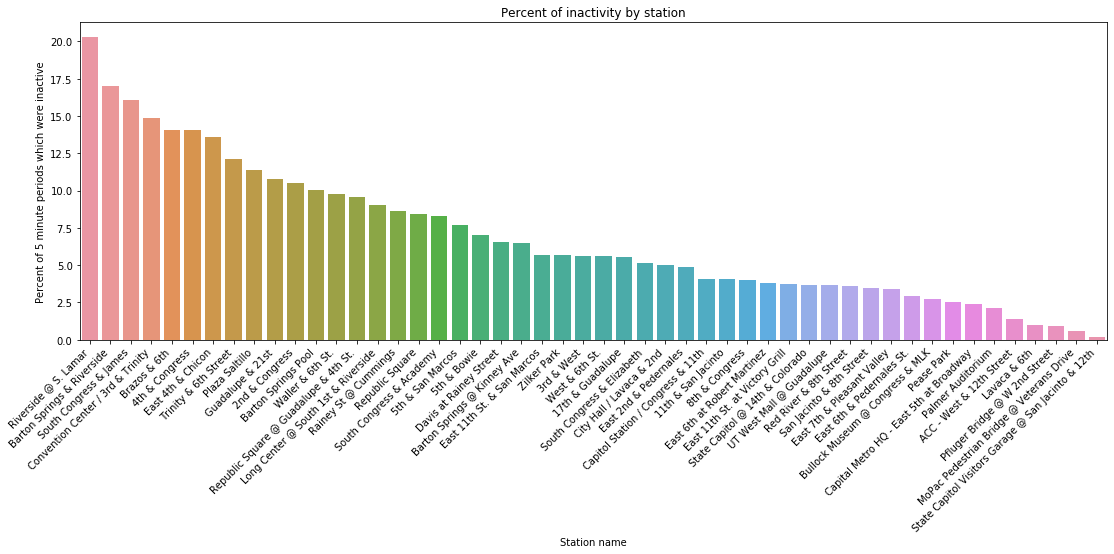

In [505]:
# visualize the entirety of the data 
fig, ax = plt.subplots(figsize=(15, 5))
plt.tight_layout()
chart = sns.barplot(percent_inactive.index, percent_inactive.active_status)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart = plt.xlabel("Station name")
chart = plt.ylabel("Percent of 5 minute periods which were inactive")
chart = plt.title("Percent of inactivity by station")

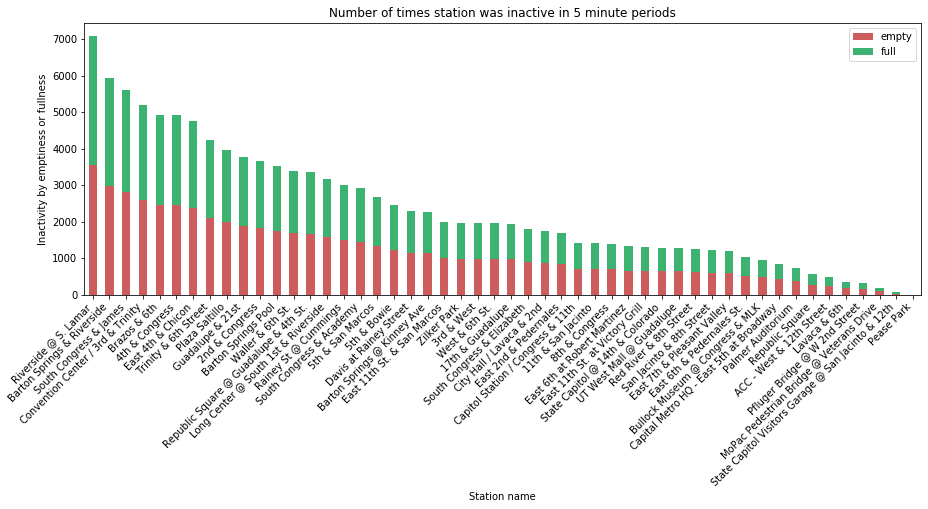

In [516]:
df = inactive_counts.drop('active_status', axis=1)
_ = df.plot.bar(stacked=True, figsize=(15, 5), color=['indianred', 'mediumseagreen'])
_.set_xticklabels(_.get_xticklabels(), rotation=45, horizontalalignment='right')
_ = plt.xlabel("Station name")
_ = plt.ylabel("Inactivity by emptiness or fullness")
_ = plt.title("Number of times station was inactive in 5 minute periods")

<div class="alert alert-success">
  <p>Looking now at data variation by station/location, we can see the stations that tend to be inactive more often than others. In our case, the stations that became inactive the most are centered around downtown areas, tourist attractions, and parks.</p>
    <p>The reason for inactivity (empty or full) is not heavily influenced by the location.
    </p>
</div>

In [650]:
# resample the weather data before merging 
weather_clean.set_index('date', inplace=True)
weather_clean = weather_clean.resample('5Min').fillna(method='ffill')
weather_clean.reset_index()

In [575]:
# go back to original data frame and rename date to merge with weather
data = bikes_stations.reset_index(level=[0,1,2])
data.rename(columns={'datetime': 'date'}, inplace=True)
data.set_index('date', inplace=True)

# merge with weather 
all_data = data.join(weather_clean, on='date')


In [639]:
dummy = station_inactivity.reset_index(level=[0,1,2])
#dummy = dummy.groupby(['datetime', 'name'])['empty', 'full', 'active_status'].count()
#dummy = dummy.reset_index(level=[0,1])

In [640]:
# want to plot number of stations that are inactive at each temperature 
# group by date, count the number that are inactive, and plot against the weather columns?
dummy = pd.DataFrame(dummy.groupby('datetime').active_status.count())
dummy = dummy.reset_index()

In [641]:
# want a dataframe with inactive count + date + temps 
tempData = all_data[['Max TemperatureF', 'Mean TemperatureF', 'Min TemperatureF']]
temps = dummy.merge(tempData, left_on='datetime', right_on='date')
#temps.groupby('name')['empty', 'full', 'active_status', 'Max TemperatureF', 'Mean TemperatureF', 'Min TemperatureF'].

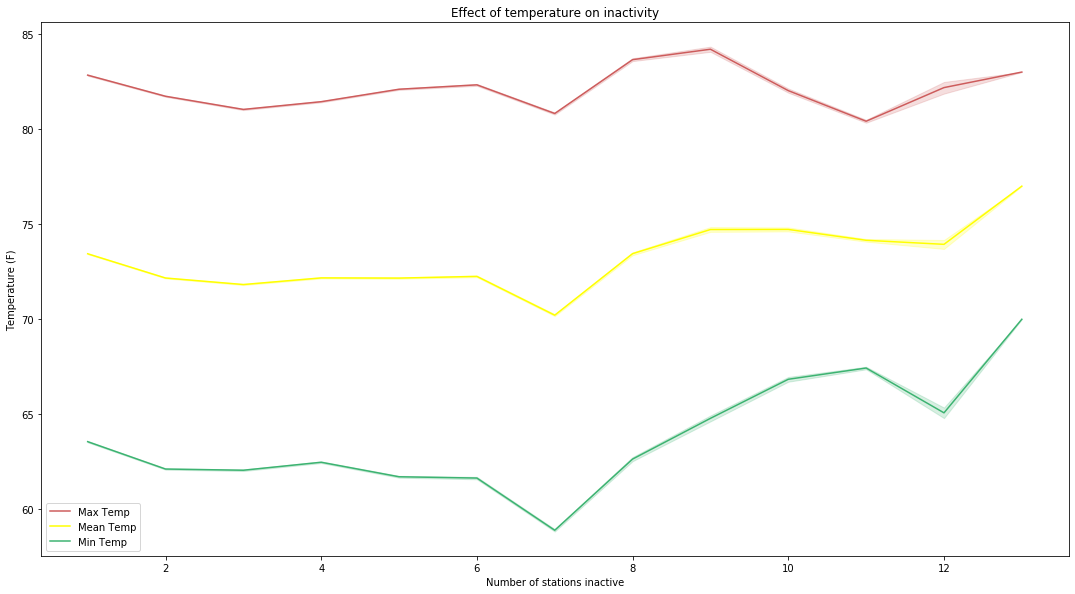

In [656]:
# temperature plots
fig, ax = plt.subplots(figsize=(15, 5))
plt.tight_layout()
_ = sns.lineplot(temps.active_status, temps['Max TemperatureF'], color="indianred", label="Max Temp")
_ = sns.lineplot(temps.active_status, temps['Mean TemperatureF'], color="yellow", label="Mean Temp")
_ = sns.lineplot(temps.active_status, temps['Min TemperatureF'], color="mediumseagreen", label="Min Temp")
_ = plt.xlabel("Number of stations inactive")
_ = plt.ylabel("Temperature (F)")
_ = plt.title("Effect of temperature on inactivity")
plt.legend()

<div class="alert alert-success">
  <p>Max, mean, and min temperature patterns vary similarly with station inactivity levels. </p>
    <p>The reason for inactivity (empty or full) is not heavily influenced by the location.
    </p>
</div>

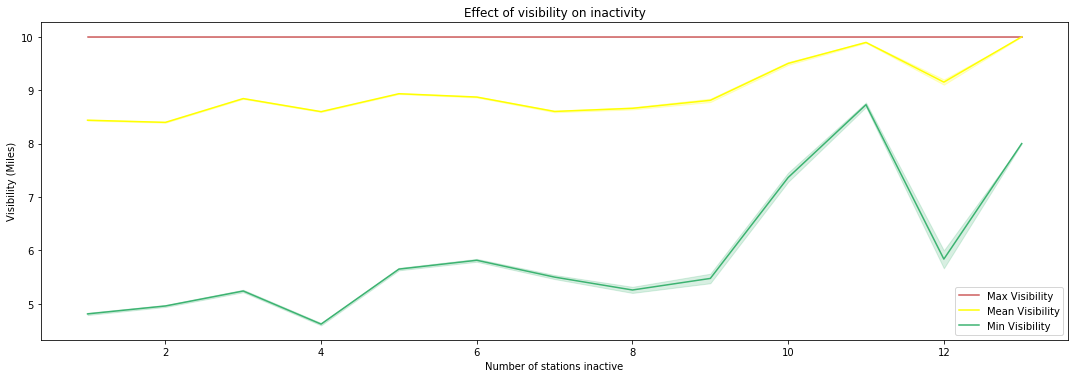

In [681]:
# visibility plots 
visData = all_data[[' Max VisibilityMiles', ' Mean VisibilityMiles', ' Min VisibilityMiles']]
vis = dummy.merge(visData, left_on='datetime', right_on='date')

fig, ax = plt.subplots(figsize=(15, 5))
plt.tight_layout()
_ = sns.lineplot(vis.active_status, vis[' Max VisibilityMiles'], color="indianred", label="Max Visibility")
_ = sns.lineplot(vis.active_status, vis[' Mean VisibilityMiles'], color="yellow", label="Mean Visibility")
_ = sns.lineplot(vis.active_status, vis[' Min VisibilityMiles'], color="mediumseagreen", label="Min Visibility")
_ = plt.xlabel("Number of stations inactive")
_ = plt.ylabel("Visibility (Miles)")
_ = plt.title("Effect of visibility on inactivity")
plt.legend()

<div class="alert alert-success">
  <p>When visibility is the high, we see more stations go inactive.</p>
</div>

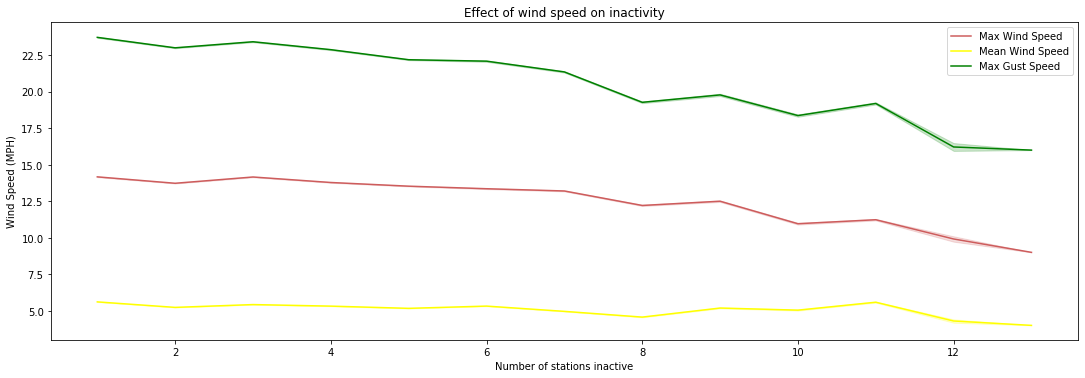

In [687]:
# wind plots 
windData = all_data[[' Max Wind SpeedMPH', ' Mean Wind SpeedMPH', ' Max Gust SpeedMPH']]
winds = dummy.merge(windData, left_on='datetime', right_on='date')

fig, ax = plt.subplots(figsize=(15, 5))
plt.tight_layout()
_ = sns.lineplot(winds.active_status, winds[' Max Wind SpeedMPH'], color="indianred", label="Max Wind Speed")
_ = sns.lineplot(winds.active_status, winds[' Mean Wind SpeedMPH'], color="yellow", label="Mean Wind Speed")
_ = sns.lineplot(winds.active_status, winds[' Max Gust SpeedMPH'], color="green", label="Max Gust Speed")
_ = plt.xlabel("Number of stations inactive")
_ = plt.ylabel("Wind Speed (MPH)")
_ = plt.title("Effect of wind speed on inactivity")
plt.legend()

<div class="alert alert-success">
  <p>Expectedly for biking, as the wind speed decreases, the number of stations inactive increases.</p>
    
</div>

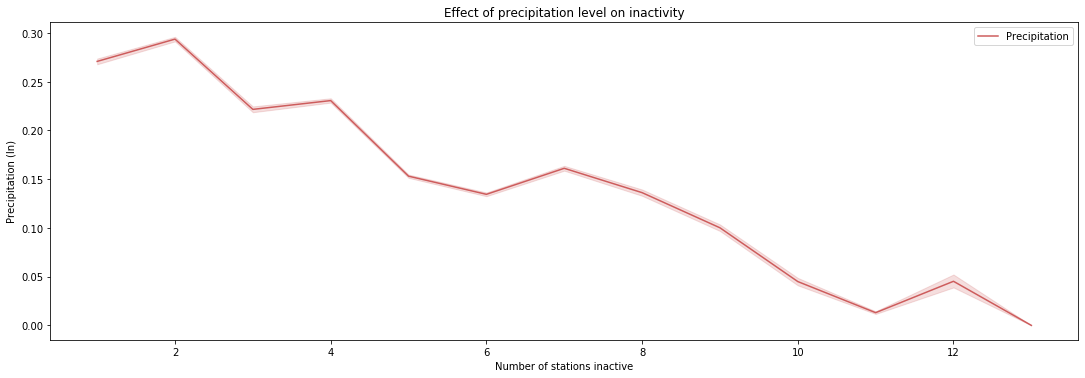

In [689]:
# precipitation
precip = all_data[['PrecipitationIn']]
precips = dummy.merge(precip, left_on='datetime', right_on='date')

fig, ax = plt.subplots(figsize=(15, 5))
plt.tight_layout()
_ = sns.lineplot(precips.active_status, precips['PrecipitationIn'], color="blue", label="Precipitation")
_ = plt.xlabel("Number of stations inactive")
_ = plt.ylabel("Precipitation (In)")
_ = plt.title("Effect of precipitation level on inactivity")
plt.legend()

<div class="alert alert-success">
  <p>Also non surprisingly, when it rained less inches in Austin, the number of stations inactive increases. This is probably due to the fact that riders typically ride more on sunny days then on rainy days.</p>
    
</div>

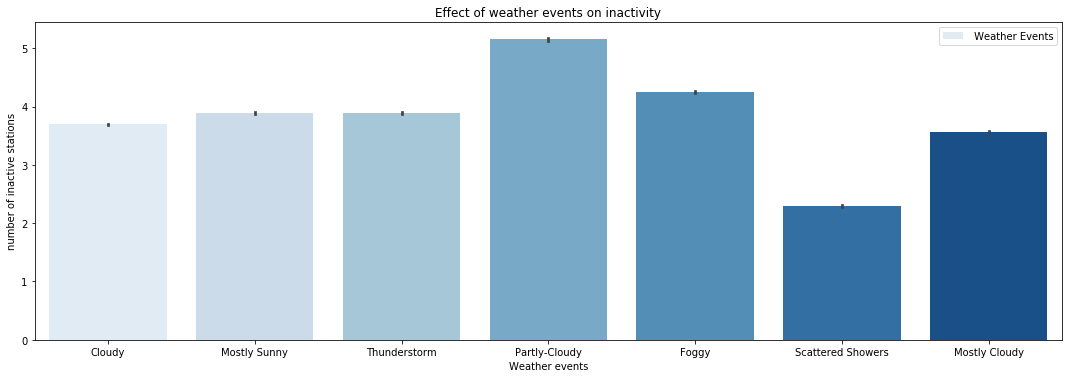

In [693]:
# cloud cover
event = all_data[[' Events']]
events = dummy.merge(event, left_on='datetime', right_on='date')
events.sort_values(by=['active_status'], ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(15, 5))
plt.tight_layout()
_ = sns.barplot(events[' Events'], events.active_status, palette="Blues", label=" Weather Events")
_ = plt.xlabel("Weather events")
_ = plt.ylabel("number of inactive stations")
_ = plt.title("Effect of weather events on inactivity")
plt.legend()

<div class="alert alert-success">
  <p>As expected from the precipitation graph, the least amount of stations are inactive during scattered showers days.</p>
    <p> Though I predicted the mostly sunny days would show highest levels of inactivity, it is actually partly-cloudy. I believe this is probably due to the fact that more time periods during the recorded months were partly-cloudy days than were sunny. </p>
</div>